In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
# from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax
import genjax.incremental
import bayes3d.scene_graph

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


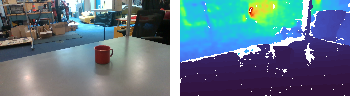

In [3]:
# files = glob.glob("./09-12-2023*.pkl")
# # all_data = pickle.load(open("tutorial_real_data.pkl", "rb"))
# file = files[4]
# print(file)
file = "./tutorial_mug_image.pkl"
all_data = pickle.load(open(file, "rb"))
IDX = 0
data = all_data[IDX]
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,2.0))

scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
rgb = rgbd_scaled_down.rgb
b.hstack_images([b.get_rgb_image(rgbd_scaled_down.rgb), b.get_depth_image(rgbd_scaled_down.depth)])

In [4]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
    jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

In [5]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)


In [35]:
def viz_trace(rgb, trace):
    b.clear_visualizer()
    b.show_cloud("obs", trace.get_retval()[0].reshape(-1,3),color=b.BLACK)
    b.show_cloud("latent", trace.get_retval()[1].reshape(-1,3),color=b.RED)
    scaling_factor = 3.0
    img = b.scale_image(
        b.get_depth_image(trace.get_retval()[1][...,2])
    , scaling_factor)
    rgb = b.scale_image(b.get_rgb_image(
        rgb
    ),scaling_factor)
    observed_depth = b.scale_image(b.get_depth_image(trace.get_retval()[0][...,2]), scaling_factor)

    return b.hstack_images([rgb, img, b.overlay_image(rgb, img, alpha=0.4), observed_depth])

def update_contact_params_in_trace(trace, cp):
    new_trace = trace.update(key, 
             genjax.choice_map({"scene": {"contact": cp}}), genjax.incremental.tree_diff_no_change(trace.get_args()))[0]
    return new_trace

def score_new_contact_param(trace, cp):
    return update_contact_params_in_trace(trace, cp).get_score()
score_new_contact_param_vmap = jax.jit(jax.vmap(score_new_contact_param, in_axes=(None,0)))

def score_new_radius(trace, radius):
    return trace.update(key, 
             genjax.choice_map({"radius": radius}), genjax.incremental.tree_diff_no_change(trace.get_args()))[0].get_score()
score_new_radius_vmap = jax.jit(jax.vmap(score_new_radius, in_axes=(None,0)))


def enumerate(min_x, max_x, min_y, max_y, min_z, max_z, num_x, num_y, num_z):   
    deltas = jnp.stack(
        jnp.meshgrid(
            jnp.linspace(min_x, max_x, num_x),
            jnp.linspace(min_y, max_y, num_y),
            jnp.linspace(min_z, max_z, num_z),
        ),
        axis=-1,
    )
    deltas = deltas.reshape(-1, 3)
    return deltas

In [36]:
import jax
import jax.numpy as jnp
from genjax.core.datatypes import JAXGenerativeFunction
from genjax.generative_functions.distributions import ExactDensity

class PixelLikelihood(ExactDensity, JAXGenerativeFunction):
    def sample(self, key, rendered_xyz, radius, outlier_prob):
        is_outlier = (jax.random.uniform(key) < outlier_prob)
        # If it's an outlier, we sample from a uniform distribution over a large interval.
        outlier_output = is_outlier * jax.random.uniform(key, minval=-100.0, maxval=100.0, shape=rendered_xyz.shape)
        # If it's not an outlier, we sample from a uniform distribution over a small interval of length `radius`
        non_outlier_output = rendered_xyz + jax.random.uniform(key, minval=-radius/2, maxval=radius/2, shape=rendered_xyz.shape)
        return outlier_output + non_outlier_output

    def logpdf(self, observed_xyz, rendered_xyz, radius, outlier_prob):
        distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
        probabilities_per_pixel = (1 - outlier_prob) * (distances < radius / 2) / radius + outlier_prob
        return jnp.log(probabilities_per_pixel)

pixel_likelihood = PixelLikelihood()

@genjax.static
def scene_generator(table_pose, box_dims):
    contact = genjax.uniform(
        jnp.array([-0.5, -0.5, -10*jnp.pi]),
        jnp.array([0.5, 0.5, 10*jnp.pi])
    ) @ "contact"
    object_pose = table_pose @ b.scene_graph.relative_pose_from_edge(
        contact,
        3,
        box_dims
    )
    rendered_image = b.RENDERER.render(object_pose[None,...], jnp.array([0]))[..., :3]
    return rendered_image, contact

@genjax.static
def single_pixel_likelihood(rendered_xyz, radius, outlier_prob):
    observed_xyz = pixel_likelihood(rendered_xyz, radius, outlier_prob) @ "observed_xyz"
    return observed_xyz

full_image_likelihood = genjax.map_combinator(in_axes=(0, None, None))(genjax.map_combinator(in_axes=(0, None, None))(single_pixel_likelihood))

@genjax.static
def full_model(table_pose, box_dims):
    rendered_image, contact = scene_generator(table_pose, box_dims) @ "scene"
    radius = genjax.uniform(0.01, 0.1) @ "radius"
    observed_image = full_image_likelihood(rendered_image, radius, 0.01) @ "observed_image"
    return observed_image, rendered_image, radius, contact
    

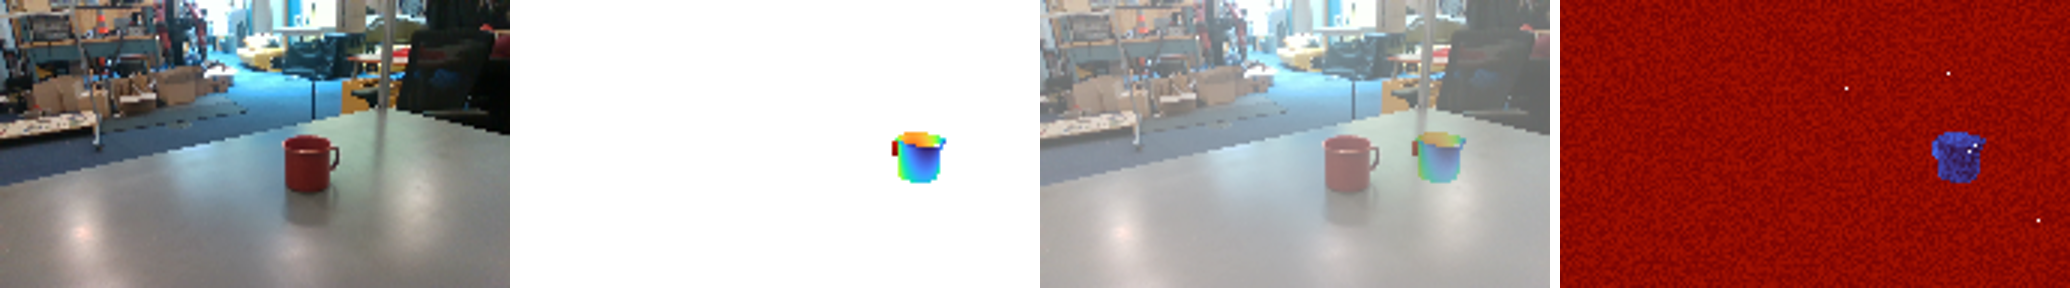

In [43]:
key = jax.random.PRNGKey(2)
trace = full_model.simulate(key, (table_pose, b.RENDERER.model_box_dims[0]))
viz_trace(rgb, trace)

Text(0, 0.5, 'Score')

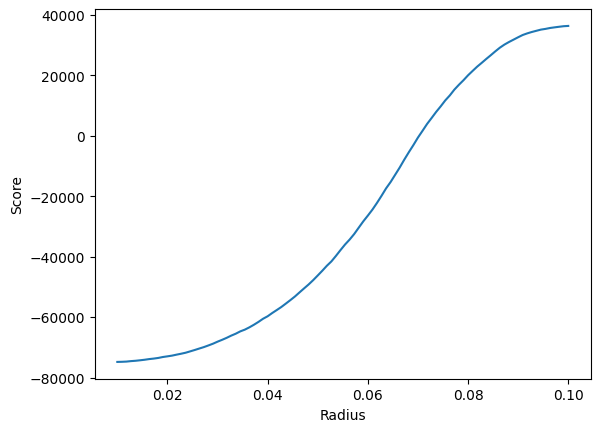

In [46]:
radius_grid = jnp.linspace(0.01, 0.1, 100)
plt.plot(radius_grid, score_new_radius_vmap(trace, radius_grid))
plt.xlabel("Radius")
plt.ylabel("Score")

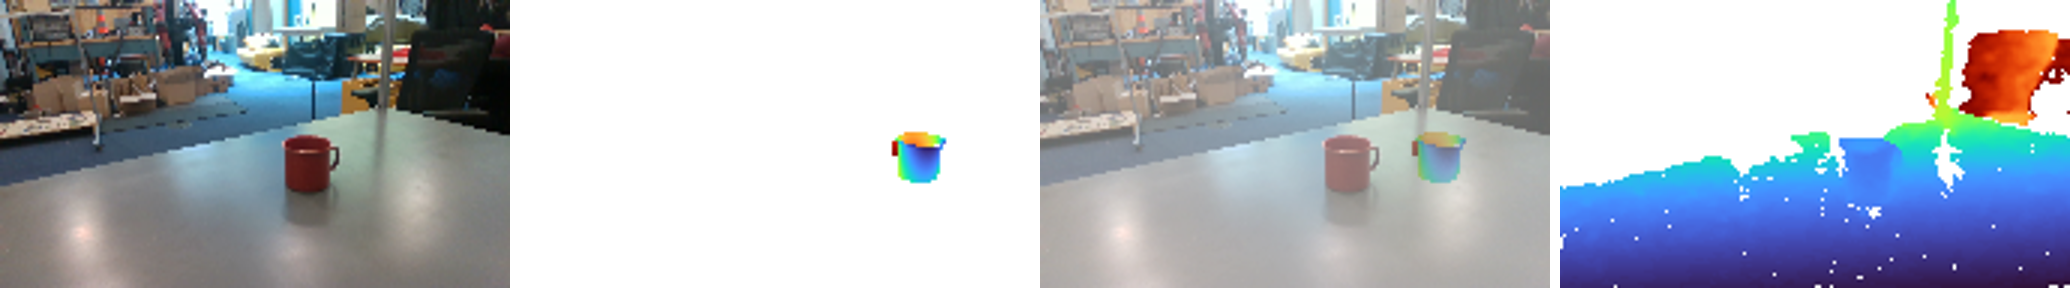

In [47]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
trace = trace.update(key, 
             genjax.choice_map({"observed_image": genjax.vector_choice_map(({"observed_xyz": genjax.choice_value(obs_img)}))}), genjax.incremental.tree_diff_no_change(trace.get_args()))[0]
viz_trace(rgb, trace)

-20471.08 -17836.266
-17836.266
-19958.756 -17741.12
-17741.12
-19387.879 -17733.799
-17733.799
-19014.611 -17733.799
-17733.799


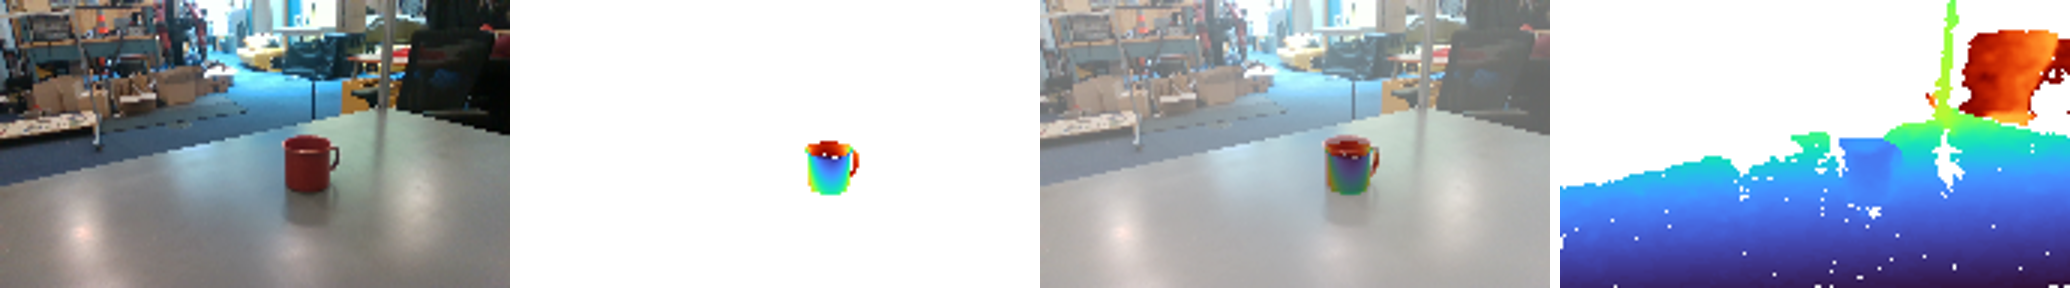

In [48]:
cp_grids = [
    enumerate(-0.3, 0.3, -0.3, 0.3, -jnp.pi, jnp.pi, 25, 25, 25),
    enumerate(-0.1, 0.1, -0.1, 0.1, -jnp.pi/2, jnp.pi/2, 25, 25, 25),
    enumerate(-0.05, 0.05, -0.05, 0.05, -jnp.pi/4, jnp.pi/4, 25, 25, 25),
    enumerate(-0.02, 0.02, -0.02, 0.02, -jnp.pi/4, jnp.pi/4, 25, 25, 25),
]

traces_at_each_inference_step = [trace]
for cp_grid in cp_grids:
    cp_grid_centered_at_current_cp = cp_grid + trace["scene","contact"]
    scores = score_new_contact_param_vmap(trace, cp_grid_centered_at_current_cp)
    print(scores.min(), scores.max())
    new_trace = update_contact_params_in_trace(trace, cp_grid_centered_at_current_cp[scores.argmax()])
    print(new_trace.get_score())
    viz_trace(rgb, new_trace)
    trace = new_trace

viz_trace(rgb, new_trace)

Text(0, 0.5, 'Score')

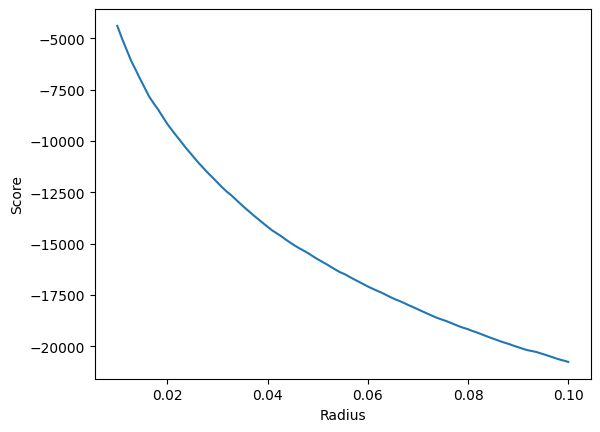

In [49]:
plt.plot(radius_grid, score_new_radius_vmap(trace, radius_grid))
plt.xlabel("Radius")
plt.ylabel("Score")